# Twitter - Timeline Analysis 1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
runlevel = 0

## Create timeline

The tweets are captured with a simple cronjob that is running the following command every minute

    /usr/local/bin/t timeline -n 10 --csv > /root/twitter/capt/twitter-data-`date +%s`.csv
    
I haven't figured out the API limit yet, so I am only capturing 10 tweets - dont want to get blacklisted. Those files are zipped up with the following commands (the first line deletes empty files which sometimes happen, as they pose problems downstream)

    find capt -size  0 -print0 | xargs -0 rm
    zip archive.zip capt/*.csv

We can copy this one locally using

    rsync user@my-twitter-server.com:/path/to/twitter/archive.zip /Users/myname/Dropbox
    
and we can get a dropbox link to the file that we use to get it locally using `wget`

In [3]:
if runlevel >= 100:
    !wget https://www.dropbox.com/s/xxx/archive.zip?dl=0 -O archive.zip
    !unzip -o archive.zip

We now glob all the files we have received and concatenate the dataframes corresponding to the csv files, after having renamed the heading  (this is where it falls over if files are of zero length)

In [217]:
if runlevel >= 95:
    filenames = glob.glob('capt/*.csv')
    tweets = pd.concat(
        [ pd.DataFrame.from_csv(fn).rename(columns = {'Posted at':'time', 'Screen name':'from', 'Text':'text' }) 
             for fn in filenames
        ])
    tweets.to_csv('tweets_raw.csv')
    tweets.tail()
    print ("==%i== tweet files converted -> tweets_raw.csv" % len (filenames) )

In [218]:
ls -l | grep tweets

-rw-r--r-- 1 root root 1025462 Sep  7 08:41 tweets.csv
-rw-r--r-- 1 root root    8104 Sep  7 08:41 tweets_per_handle.csv
-rw-r--r-- 1 root root      89 Sep  7 08:41 tweets_per_utc1.csv
-rw-r--r-- 1 root root  892569 Sep  7 08:41 tweets_raw.csv


In [219]:
tweets = pd.DataFrame.from_csv('tweets_raw.csv')
print ("number of tweets: %i" % len(tweets))
tweets.head()

number of tweets: 5297


,time,from,text
ID,,,
508463857913036802,2014-09-07 03:56:45 +0000,tomgara,Is Conrad Hackett a person or an idea?
508463793504931842,2014-09-07 03:56:29 +0000,PaulGambles2,RT @MLutherKingQts: A productive and happy lif...
508463703197765632,2014-09-07 03:56:08 +0000,Sally_Hadidi,Sonoma wine tasting picnics in the sun #Califo...
508463524062830592,2014-09-07 03:55:25 +0000,A_Reader_FT,RT @SaoSasha: You can accuse the Czechs of man...
508463450109255680,2014-09-07 03:55:07 +0000,RightWingNews,Even More IRS Empoyees Have “Lost” Emails http...


In [220]:
if runlevel >= 90:
    from datetime import datetime as dt
    def convert_time(t):
        o = dt.strptime(t, "%Y-%m-%d %H:%M:%S %z")
        return o.hour + o.minute/60, o.hour, (o.hour//3)*3, (o.hour//6)*6, (o.hour//12)*12, o.weekday()

    df1 = pd.DataFrame([ convert_time(t) for t in tweets['time']], 
                           columns=['utc', 'utc1', 'utc3', 'utc6', 'utc12', 'wday'], index=tweets.index)
    for col in df1.columns:
        tweets[col] = df1[col]
    tweets.to_csv('tweets.csv')
    print ("reformatted time data (%i tweets)" % len(tweets))

## Basic analysis

In [221]:
tweets = pd.DataFrame.from_csv('tweets.csv')
tweets.head()

,time,from,text,utc,utc1,utc3,utc6,utc12,wday
ID,,,,,,,,,
508463857913036802,2014-09-07 03:56:45 +0000,tomgara,Is Conrad Hackett a person or an idea?,3.933333,3,3,0,0,6
508463793504931842,2014-09-07 03:56:29 +0000,PaulGambles2,RT @MLutherKingQts: A productive and happy lif...,3.933333,3,3,0,0,6
508463703197765632,2014-09-07 03:56:08 +0000,Sally_Hadidi,Sonoma wine tasting picnics in the sun #Califo...,3.933333,3,3,0,0,6
508463524062830592,2014-09-07 03:55:25 +0000,A_Reader_FT,RT @SaoSasha: You can accuse the Czechs of man...,3.916667,3,3,0,0,6
508463450109255680,2014-09-07 03:55:07 +0000,RightWingNews,Even More IRS Empoyees Have “Lost” Emails http...,3.916667,3,3,0,0,6


### Tweets per hour

In [222]:
utc1s = {x for x in tweets['utc1']}
utc1s

{0, 1, 2, 3, 4, 5, 6, 7, 8, 20, 21, 22, 23}

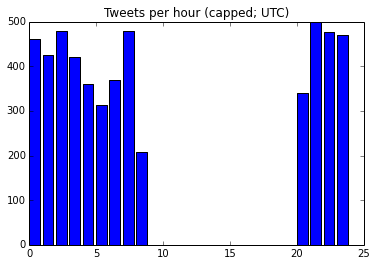

In [223]:
if runlevel >= 0:
    mylist = [  (  utc1, len(tweets[tweets['utc1']==utc1])) for utc1 in utc1s]
    mylist.sort(key = lambda x: int(x[0]), reverse=False)
    index = [x[0] for x in mylist]
    data = [x[1] for x in mylist]
    tweets_per_utc1 = pd.DataFrame(data, index=index, columns=['count'])
    mylist,index,data = None,None,None
    tweets_per_utc1.to_csv('tweets_per_utc1.csv')
    
tweets_per_utc1 = pd.DataFrame.from_csv('tweets_per_utc1.csv')
plt.bar(tweets_per_utc1.index, tweets_per_utc1['count'])
plt.title('Tweets per hour (capped; UTC)')

Note: because we only get 10 teets per minute this analysis will max out at 600 tweets / hour, regardless of how many tweets are being sent; this *is* a binding constraint, so with the present data this graph is probably not very meaningful

### Tweets per sender
We first look at the twitter handles that send messages into my timeline (note: for new-style RT's I won't see who RT'd it, and I also might not follow the tweep); we look at some basic stats (#tweets, #tweeps, #tweets/tweep)

In [224]:
handles = {x for x in tweets['from']}
#handles

In [225]:
len(tweets), len(handles), round(len(tweets) / len(handles),2)

(5297, 580, 9.13)

In [226]:
if runlevel > 80:
    mylist = [  (  handle, len(tweets[tweets['from']==handle])  )
      for handle in handles]
    mylist.sort(key = lambda x: x[1], reverse=True)
    index = [x[0] for x in mylist]
    data = [x[1] for x in mylist]
    tweets_per_handle = pd.DataFrame(data, index=index, columns=['count'])
    mylist,index,data = None,None,None
    tweets_per_handle.to_csv('tweets_per_handle.csv')
    print ("calculated number of tweets per handle (%i handles)" % len(handles))

tweets_per_handle = pd.DataFrame.from_csv('tweets_per_handle.csv')
tweets_per_handle.head(20)

,count
ManchurianDevil,186
luvronandez,143
CMCMFIN,120
Ed_Tech_,107
saserief,86
beccanalia,75
ao_techfreak,71
AnnieSage,69
Arinobe_SME,66
WarrenWhitlock,61


In [227]:
average(tweets_per_handle), median(tweets_per_handle)

(9.1327586206896552, 4.0)

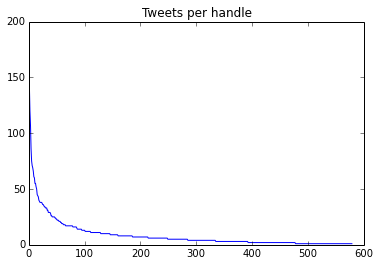

In [239]:
plt.plot(tweets_per_handle)
plt.title('Tweets per handle')

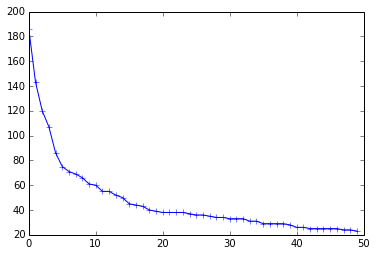

In [229]:
plt.plot(tweets_per_handle[:50], '+-')

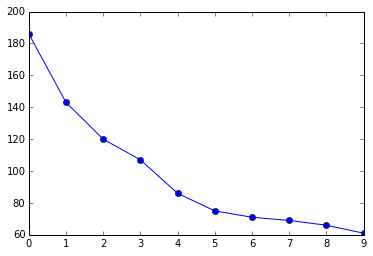

In [230]:
plt.plot(tweets_per_handle[:10], 'o-')

## Streaming API

In [231]:
import twitter
import yaml

In [232]:
if False:
    with open("twitter_tokens.yaml", "w") as f:
        yaml.dump(tok, f, default_flow_style=False)
!ls -l | grep yaml

-rw-r--r-- 1 root root     226 Sep  7 07:10 twitter_tokens.yaml


In [233]:
with open("twitter_tokens.yaml", "r") as f:
    tok = yaml.load(f.read())
#tok

auth_obj=twitter.OAuth(
    token = tok['token'], 
    token_secret = tok['token_secret'], 
    consumer_key = tok['consumer_key'], 
    consumer_secret = tok['consumer_secret']
)
auth_obj

In [238]:
#t = twitter.Twitter(auth=auth_obj)

In [235]:
#status = t.statuses.home_timeline(count=5)
#status[0]

In [237]:
#twitter_stream = twitter.TwitterStream(auth=auth_obj, domain='userstream.twitter.com')
twitter_stream = twitter.TwitterStream(auth=auth_obj)
#twitterator = twitter_stream.user()
#twitterator = twitter_stream.statuses.sample()
#twitterator

In [ ]:
if False:
    import pprint
    for tweet in twitterator:
        #print ('incoming')
        pprint (tweet)
    